In [2]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import cv2

In [3]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [8]:
# Path to the directory containing the bike images
bikes_folder = "bikes"
# List all files in the bikes folder
bike_images = os.listdir(bikes_folder)

real_labels = [1] * 10 + [0] * 10
computed_labels = []

for image_file in bike_images:
    image_path = os.path.join(bikes_folder, image_file)
    
    # Open the image file in binary mode
    with open(image_path, "rb") as img_file:
        # Analyze the image using Computer Vision API, specifying objects detection
        result = computervision_client.analyze_image_in_stream(img_file, visual_features=[VisualFeatureTypes.tags, VisualFeatureTypes.objects])

        isBike = 0
        for tag in result.tags:
            if any(keyword in tag.name for keyword in ["bike", "bicycle"]):
                isBike = 1

        if isBike:
            computed_labels.append(1)
        else:
            computed_labels.append(0)

print(real_labels)
print(computed_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [15]:
# Define the function to extract features from the given images
def extract_features(folder, computervision_client):
    features = []
    labels = []
    
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder, filename)
            
            with open(image_path, "rb") as img_file:
                # Analyze the image using Computer Vision API, specifying objects detection
                result = computervision_client.analyze_image_in_stream(img_file, visual_features=['Tags'])
                
                # Check if any of the tags contain 'bike' or 'bicycle'
                is_bike = any(tag.name.lower() in ['bike', 'bicycle'] for tag in result.tags)
                
                # Append the length of the filename as a simple feature
                features.append(len(filename))
                
                # Assign labels: 1 for 'bike' images, 0 for others
                labels.append(1 if is_bike else 0)
    
    return np.array(features).reshape(-1, 1), np.array(labels)

# Loading the data and extracting features
bikes_folder = "bikes"

features, real_labels = extract_features(bikes_folder, computervision_client)

# Training an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(features, real_labels)

# Calculating the predicted labels
computed_labels = svm_classifier.predict(features)

print(real_labels)
print(computed_labels)

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


In [16]:
# Function for evaluating performance
# using the sklearn functions

def eval_classification(real_labels, computed_labels):
    acc = accuracy_score(real_labels, computed_labels)
    prec = precision_score(real_labels, computed_labels)
    recall = recall_score(real_labels, computed_labels)
    return acc, prec, recall


# Evaluating performance
acc, prec, recall = eval_classification(real_labels, computed_labels)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', recall)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


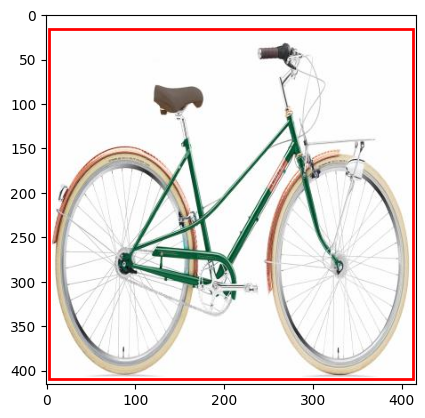

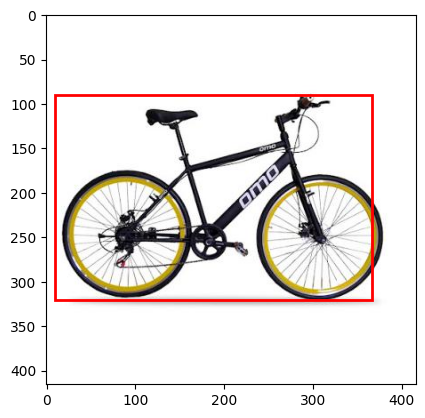

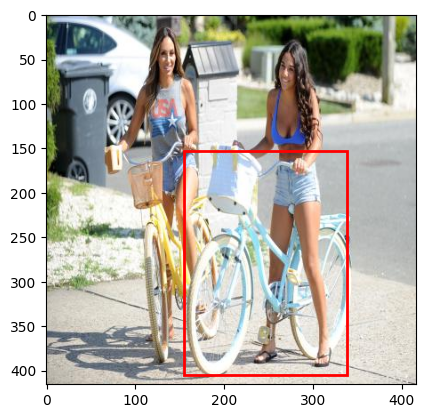

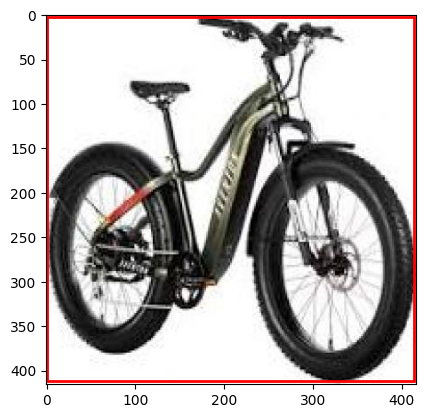

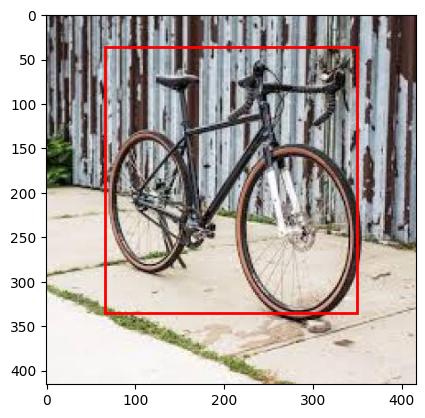

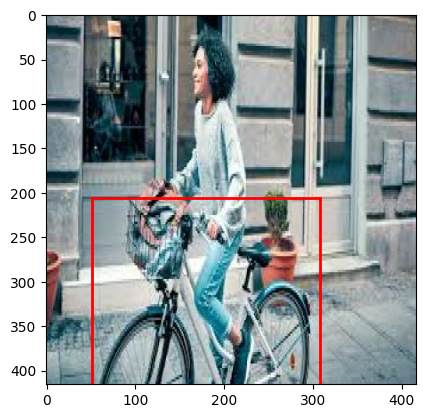

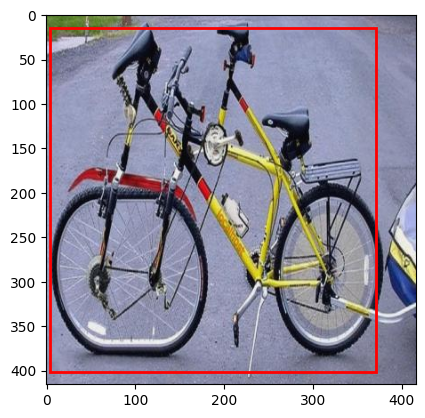

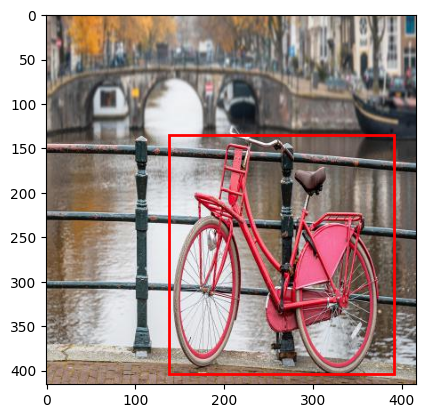

In [17]:
# Path to the directory containing the bike images
bikes_folder = "bikes"
# List all files in the bikes folder
bike_images = os.listdir(bikes_folder)

predicted_boxes = []

for image_file in bike_images:
    image_path = os.path.join(bikes_folder, image_file)
    
    # Open the image file in binary mode
    with open(image_path, "rb") as img_file:
        # Analyze the image using Computer Vision API, specifying objects detection
        result = computervision_client.analyze_image_in_stream(img_file, visual_features=[VisualFeatureTypes.objects])
        
        for ob in result.objects:
            if ob.object_property == "bicycle":
                # Load the image
                im = plt.imread(image_path)
                fig, ax = plt.subplots()
                ax.imshow(im)
        
                # Get the coordinates of the detected bicycle
                predicted_bike_bb = [ob.rectangle.x, ob.rectangle.y, ob.rectangle.x + ob.rectangle.w, ob.rectangle.y + ob.rectangle.h]
                # Draw a rectangle around the detected bicycle
                rect = plt.Rectangle((predicted_bike_bb[0], predicted_bike_bb[1]),
                                     width=predicted_bike_bb[2] - predicted_bike_bb[0],
                                     height=predicted_bike_bb[3] - predicted_bike_bb[1],
                                     edgecolor='r', linewidth=2, fill=False)
                ax.add_patch(rect)

                predicted_boxes.append(predicted_bike_bb)
        plt.show()

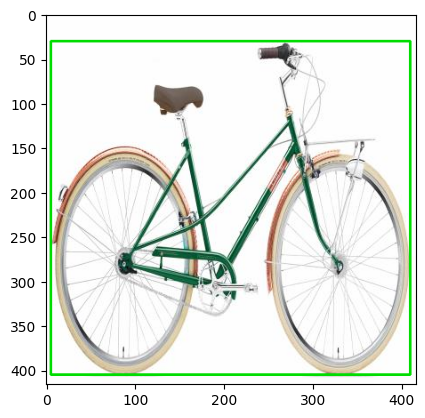

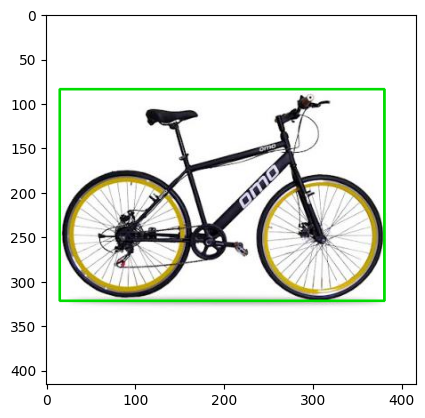

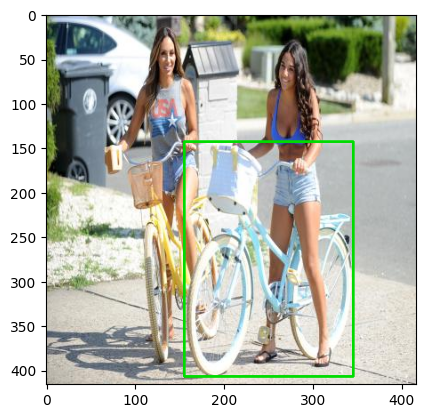

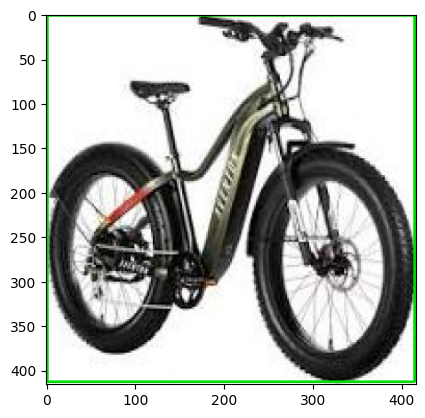

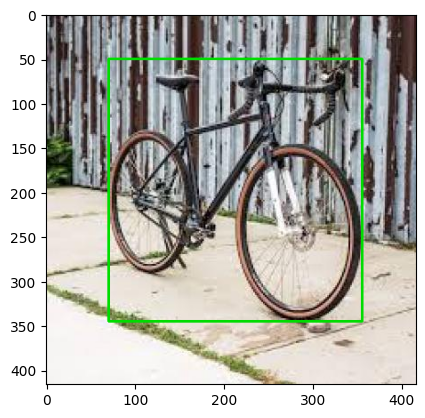

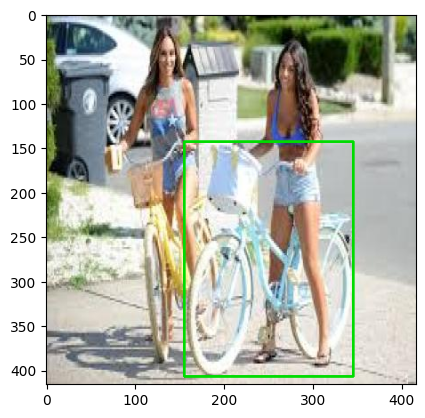

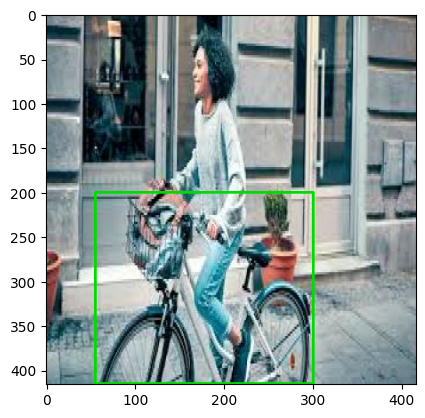

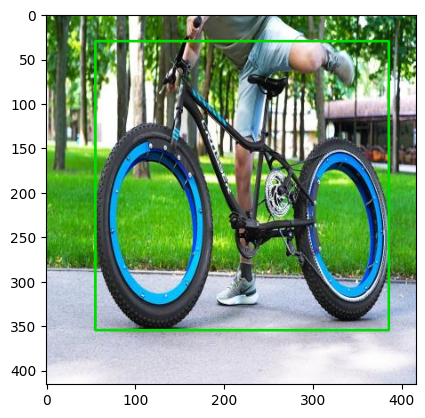

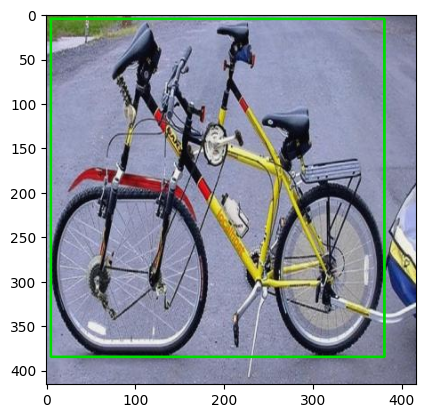

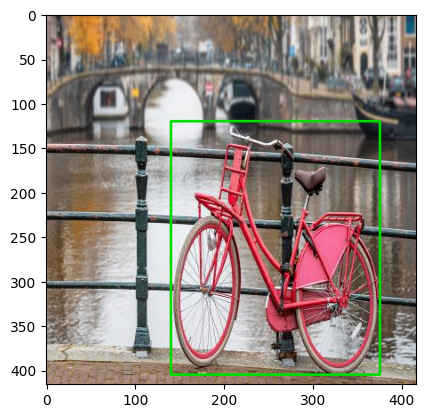

In [18]:
bike_images = [file for file in os.listdir(bikes_folder) if file.startswith("bike") and file[4:6].isdigit() and int(file[4:6]) <= 10]

labeled_boxes = []

i = 1
for image_name in bike_images:
    image_path = os.path.join(bikes_folder, image_name)
    image = cv2.imread(image_path)
    
    if i == 1:
        labeled_boxes.append((5, 30, 409, 405))
        cv2.rectangle(image, (5, 30), (409, 405), (0, 220, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    if i == 2:
        labeled_boxes.append((15, 84, 380, 322))
        cv2.rectangle(image, (15, 84), (380, 322), (0, 220, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    if i == 3:
        labeled_boxes.append((155, 143, 345, 407))
        cv2.rectangle(image, (155, 143), (345, 407), (0, 220, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    if i == 4:
        labeled_boxes.append((1, 1, 414, 413))
        cv2.rectangle(image, (1, 1), (414, 413), (0, 220, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    if i == 5:
        labeled_boxes.append((70, 50, 355, 345))
        cv2.rectangle(image, (70, 50), (355, 345), (0, 220, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    if i == 6:
        labeled_boxes.append((155, 143, 345, 407))
        cv2.rectangle(image, (155, 143), (345, 407), (0, 220, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    if i == 7:
        labeled_boxes.append((55, 200, 300, 415))
        cv2.rectangle(image, (55, 200), (300, 415), (0, 220, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    if i == 8:
        labeled_boxes.append((55, 30, 385, 355))
        cv2.rectangle(image, (55, 30), (385, 355), (0, 220, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    if i == 9:
        labeled_boxes.append((5, 5, 380, 385))
        cv2.rectangle(image, (5, 5), (380, 385), (0, 220, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
    if i == 10:
        labeled_boxes.append((140, 120, 375, 405))
        cv2.rectangle(image, (140, 120), (375, 405), (0, 220, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
        
    i += 1

In [19]:
def calculate_iou(boxA, boxB):
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Compute IoU and accuracy
iou_values = []
correct_predictions = 0

for predicted_box, labeled_box in zip(predicted_boxes, labeled_boxes):
    iou = calculate_iou(predicted_box, labeled_box)
    iou_values.append(iou)
    
    if iou >= 0.5:  # Assuming a threshold of 0.5 for a correct prediction
        correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / len(predicted_boxes)

print("Average IoU:", sum(iou_values) / len(iou_values))
print("Accuracy:", accuracy)

Average IoU: 0.7345114953428893
Accuracy: 0.625
